### Return Attribution

In this section, we introduce a technique for assigning weights to these samples to train a machine learning algorithm. Highly overlapping results will have disproportionate weights compared to non-overlapping results. At the same time, labels associated with large absolute returns are more important than labels with negligibly small absolute returns. Simply put, observations must be weighted using a function that takes both eigenvalue and absolute return into account.

When label is a function of the return sign, the sample weight can be defined by the sum of the contribution returns over the event's life cycle $[t_{i,0}, t_{i,1}]$.

$$\tilde{w_i} = \begin{vmatrix} \sum_{t = t_{i,0}}^{t_{i,1}} \frac{r_{t-1}, t}{c_{t}}\end{vmatrix}$$

$$w_i = \tilde{w_i} I \left( \sum_{j=1}^I \tilde{w_j}\right)$$

Therefore, $\sum_{i=1}^I w_i = I$. The library generally assumes that the default weight of algorithmic parameters is 1, so we adjusted the size of this weight so that the sum is $I$.

The logic of this method is that we want to express the weight of an observation as a function of its absolute log return, which can uniquely affect the observation. However, if a 'neutral' case exists for this method, it will not work. In this case, lower returns should be given a higher weight, not a lower weight. Ultimately, the 'neutral' case is unnecessary because it means predicting '-1' or 1' with low confidence. The code below implements this method.

In [2]:
# Setup path to import modules
import sys
from pathlib import Path

# Add the MLFinance root directory to Python path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # Go up from Notes/Week05Labeling to MLFinance
equity_ml_root = project_root.parent  # Go up to equity-ml-ldp

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✓ Added {project_root} to Python path")
    
if str(equity_ml_root) not in sys.path:
    sys.path.insert(0, str(equity_ml_root))
    print(f"✓ Added {equity_ml_root} to Python path")

✓ Added /mnt/ssd_backup/equity-ml-ldp/MLFinance/Notes to Python path
✓ Added /mnt/ssd_backup/equity-ml-ldp/MLFinance to Python path


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from FinancialMachineLearning.labeling.labeling import *
from FinancialMachineLearning.features.volatility import daily_volatility
from FinancialMachineLearning.sample_weights.concurrency import *
from FinancialMachineLearning.utils.multiprocess import *

start_date = '2000-01-01'
end_date = '2024-04-10'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date,
    multi_level_index=False,
    auto_adjust=True
)

[*********************100%***********************]  1 of 1 completed


In [6]:
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 7 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-10
2000-01-04   2000-01-11
2000-01-05   2000-01-12
2000-01-06   2000-01-13
2000-01-07   2000-01-14
Name: Date, dtype: datetime64[ns]

In [7]:
volatility = daily_volatility(
    data['Close'], 
    lookback = 60 # moving average span
)

In [11]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 12, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

2025-10-19 13:57:09.584187 100.0% apply_pt_sl_on_t1 done after 0.01 minutes. Remaining 0.0 minutes..


,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.016797,2,1
2000-01-10,2000-01-12,0.026414,2,1
2000-01-11,2000-01-12,0.024043,2,1
2000-01-12,2000-01-13,0.031168,2,1
2000-01-13,2000-01-19,0.050703,2,1


In [12]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [13]:
labels.head()

,ret,trgt,bin
Date,,,
2000-01-07,-0.067839,0.016797,-1
2000-01-10,-0.108056,0.026414,-1
2000-01-11,-0.059973,0.024043,-1
2000-01-12,0.109677,0.031168,1
2000-01-13,0.101421,0.050703,0


In [14]:
triple_barrier_events['side'] = labels['bin']
triple_barrier_events.head()

,t1,trgt,pt,sl,side
Date,,,,,
2000-01-07,2000-01-11,0.016797,2,1,-1.0
2000-01-10,2000-01-12,0.026414,2,1,-1.0
2000-01-11,2000-01-12,0.024043,2,1,-1.0
2000-01-12,2000-01-13,0.031168,2,1,1.0
2000-01-13,2000-01-19,0.050703,2,1,0.0


In [19]:
num_threads = 1
num_conc_events = mp_pandas_obj(
    concurrent_events, 
    ('molecule', triple_barrier_events.index), 
    num_threads, 
    close_series_index = data['Close'].index, 
    label_endtime = triple_barrier_events['t1']
)

In [20]:
num_conc_events = num_conc_events.reindex(data['Close'].index).fillna(0)

In [21]:
triple_barrier_events[:-5]

,t1,trgt,pt,sl,side
Date,,,,,
2000-01-07,2000-01-11,0.016797,2,1,-1.0
2000-01-10,2000-01-12,0.026414,2,1,-1.0
2000-01-11,2000-01-12,0.024043,2,1,-1.0
2000-01-12,2000-01-13,0.031168,2,1,1.0
2000-01-13,2000-01-19,0.050703,2,1,0.0
...,...,...,...,...,...
2024-03-26,2024-04-02,0.018165,2,1,0.0
2024-03-27,2024-04-03,0.018154,2,1,-1.0
2024-03-28,2024-04-04,0.018015,2,1,0.0


In [22]:
from FinancialMachineLearning.sample_weights.attribution import *

return_weights = weights_by_return(triple_barrier_events[:-5], data['Close'][:-5], num_threads = 1)

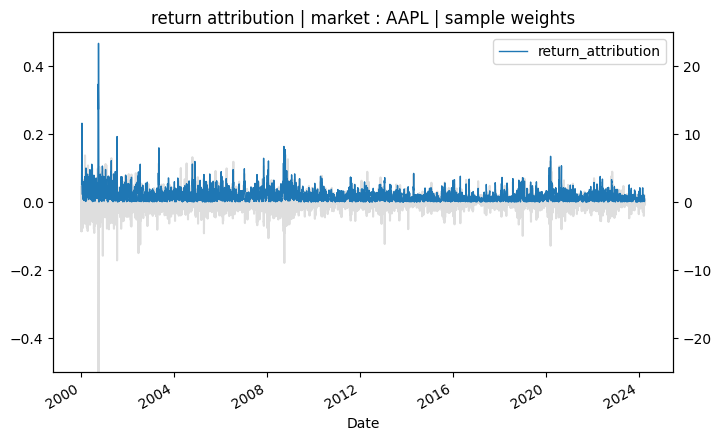

In [23]:
fig, ax = plt.subplots(figsize = (8, 5))
data['Close'].pct_change().plot(alpha = 0.75, ax = ax, color = 'lightgray')
plt.ylim([-0.5, 0.5])
plt.grid(False)

return_weights.plot(secondary_y=True, lw = 1)
plt.ylim([-25, 25])
plt.legend(['return_attribution'])
plt.grid(False)

plt.title('return attribution | market : AAPL | sample weights')
plt.show()